In [84]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from  sklearn.metrics import mean_squared_error

# I transformed the txt files into csv just because they are a bit simpler to manage
# added the title row at the beginning: "time" "velocity" "force"
# I use only numerical_data.csv to train, and experimental_data.csv to test the model,
# If you think that it is better you can merge the files (but then you will have to find other data
# to test th model), or swap them (train with experimental and test with numerical data)

train = pd.read_csv("numerical_data.csv", sep=",")

# INPUT:  ONLY VELOCITY
# OUTPUT: ONLY FORCE
# change this value to N if you want to use N previous values
timestep = 1  # for Reshape_input etc.

# with timestep = 10 I found:
# MSE 2.7140929919153043e-06 for train scaled values
# MSE 0.0016335511228334893 for train scaled back values
# MSE 1.2209993163934232e-05 for test scaled values
# MSE 0.010834463731322736 for test scaled back values

In [85]:
 train.shape

(30001, 3)

In [86]:
train.head() 

,time,velocity,force
0,0.000,0.000000e+00,-0.000017
1,0.001,-7.040000e-09,-0.000017
2,0.002,-7.650000e-05,0.006806
3,0.003,-2.157000e-04,0.019206
4,0.004,-4.113000e-04,0.036630


In [87]:
 train.dtypes

time        float64
velocity    float64
force       float64
dtype: object

In [88]:
train.corr()


,time,velocity,force
time,1.00000,-0.014960,0.014950
velocity,-0.01496,1.000000,-0.999996
force,0.01495,-0.999996,1.000000


In [89]:
#from sklearn.preprocessing import StandardScaler

In [90]:
from sklearn.preprocessing import MinMaxScaler

In [91]:
enc1=MinMaxScaler(feature_range=(0,1))
# I added explicitly the range even if it's default


In [92]:
def Reshape_input(train,transform_only):
    # timestep = 10 moved outside, so if you change it you can adjust everything
    
    # I applied transform to y too
    # Important points about LSTM models:
    # - they predict time series: given n measures (e.g. 10 ) at time t1...tn 
    #     they compute pred. measure at time tn+1 (e.g. at t=11)
    # - so the "features" are the n measures and the "label" is the n+1th measure (sliding along the data)
    # - quite often they are used with time series consisting of 1 measure only, but we have 2 
    #     (velocity and force)
    # - so we have to use a 2-dimensional time series, and also velocities will be predicted...
    
    #X ,y = train.iloc[:,:1],train.iloc[timestep:,2]
    X = train.iloc[:,1:]
    if transform_only:
        X= enc1.transform(X)
    else:
        X= enc1.fit_transform(X)
#    X_3d = np.zeros((X.shape[0]-timestep,timestep,X.shape[1]))
#    y = np.zeros((X.shape[0]-timestep,X.shape[1]))
    X_3d = np.zeros((X.shape[0]-timestep,timestep,1))
    y = np.zeros((X.shape[0]-timestep,1))
    print(y.shape)
    
    for i in range(X_3d.shape[0]):
        X_3d[i,:,0] = X[i:i+timestep,0]
        y[i,0] = X[i+timestep,1]
    return enc1, X_3d, y


In [93]:
enc1, X, y = Reshape_input(train,transform_only=False)

(30000, 1)


In [94]:
X.shape

(30000, 1, 1)

In [95]:
print(X[0:2]) # to see that actually the 10 values of velocity "slide"

[[[0.49957592]]

 [[0.4995759 ]]]


In [96]:
y.shape

(30000, 1)

In [97]:
print(y[0:2])  # this is force, nothing to do with the X values

[[0.49934963]
 [0.49960732]]


In [98]:
from keras.models import Sequential
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import *
model = Sequential()
# I did not change the model here, just make some small experiments. 
# Probably you should compare the model and parameters to the ones you used in Matlab, and tune them a bit...
# I tried also with recurrent_dropout = 0.1 (no better results)
model.add(LSTM(18, input_shape=(X.shape[1], X.shape[2]), recurrent_dropout= 0))
# From your messages I'd expect only the LSTM and one Dense for output, but I did not change here
model.add(Dense(18,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0))
# Here we need 2 because our data are velocity AND force!
model.add(Dense(1))
model.add(Dense(1,activation='linear'))
# Iadded explicit lr to Adam optimizer, tried several values and 
#   varied also min_lr accordingly in ReduceRLOnPlateau; 
# I tried also with SGD (no better results)
model.compile(Adam(lr=0.01), loss='mean_squared_error')

checkpoint = ModelCheckpoint(filepath='model_lstm_yusra_weights.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4,
                          verbose=0, mode='auto')
# tried also with smaller min_lr
RL = ReduceLROnPlateau(min_lr=0.0001,factor=0.3,patience=3)

In [99]:
# tried with batch sizes 32, 64, 512, etc.; validation_split=0.2
history = model.fit(X, y, epochs=100, batch_size=32,validation_split=0.25,
                  verbose=1, shuffle=False,callbacks=[checkpoint,RL,EarlyStop])

Train on 22500 samples, validate on 7500 samples
Epoch 1/100
22500/22500 [==============================] - 2s 73us/step - loss: 0.0233 - val_loss: 0.0185
Epoch 2/100
22500/22500 [==============================] - 1s 41us/step - loss: 0.0118 - val_loss: 0.0118
Epoch 3/100
22500/22500 [==============================] - 1s 41us/step - loss: 0.0025 - val_loss: 3.2559e-04
Epoch 4/100
22500/22500 [==============================] - 1s 41us/step - loss: 1.3752e-04 - val_loss: 9.3932e-04
Epoch 5/100
22500/22500 [==============================] - 1s 41us/step - loss: 7.2881e-04 - val_loss: 0.0040
Epoch 6/100
22500/22500 [==============================] - 1s 41us/step - loss: 6.7205e-04 - val_loss: 0.0059
Epoch 7/100
22500/22500 [==============================] - 1s 40us/step - loss: 1.2480e-04 - val_loss: 4.6351e-05
Epoch 8/100
22500/22500 [==============================] - 1s 42us/step - loss: 2.1567e-05 - val_loss: 2.0340e-04
Epoch 9/100
22500/22500 [==============================] - 1s 42us/

In [100]:
pp=model.predict(X) # now we get the prdictions (scaled velocities and forces)

In [101]:
mean_squared_error(pp,y)

# with timestep 10 I got here 2.7140929919153043e-06


7.14871875502154e-06

In [102]:
# scale back and compute mse between force and predicted force
#pp.shape
pp_back=np.zeros((pp.shape[0],2))
for i in range(pp.shape[0]):
    pp_back[i,1] = pp[i]

pp_back=enc1.inverse_transform(pp_back)
#pp_back.shape
mean_squared_error(pp_back[:,1],train["force"][timestep:])

# with timestep 10 I got here 0.0016335511228334893

0.0050116645869795196

In [103]:
"""Step 2 - Make a dataframe with one  file from  Z=1.5"""

'Step 2 - Make a dataframe with one  file from  Z=1.5'

In [104]:
test = pd.read_csv("experimental_data.csv", sep=",")
# using this file to test the model

In [105]:
test.head()

,time,velocity,force
0,0.000,0.0,0.0
1,0.001,0.0,0.0
2,0.002,0.0,0.0
3,0.003,0.0,0.0
4,0.004,0.0,0.0


In [106]:
test.dtypes

time        float64
velocity    float64
force       float64
dtype: object

In [107]:
enc1, X, y = Reshape_input(test,transform_only=False)

(30000, 1)


In [108]:
#X = X.reshape((X.shape[0], 1, X.shape[1]))

In [109]:
model.load_weights('model_lstm_yusra_weights.hdfs')

In [110]:
pred1=model.predict(X)
    

In [111]:
mean_squared_error(pred1,y)
# with timestep 10 I got here 1.2209993163934232e-05

1.4351147268874845e-05

In [112]:

pred1_back=np.zeros((pred1.shape[0],2))
for i in range(pred1.shape[0]):
    pred1_back[i,1] = pred1[i]

pred1_back=enc1.inverse_transform(pred1_back)
#pp_back.shape
mean_squared_error(pred1_back[:,1],test["force"][timestep:])

# with timestep 10 I got here 0.010834463731322736

0.012734403901778744

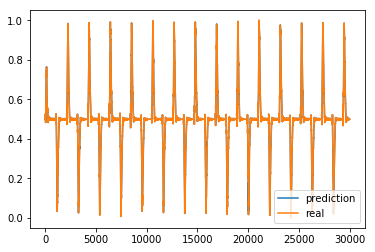

In [113]:
from matplotlib  import pyplot  as plt
fig, ax=plt.subplots()
ax.plot(list(pred1[:]), label='prediction')
ax.plot(list(y[:]), label='real')
plt.legend()
plt.show()

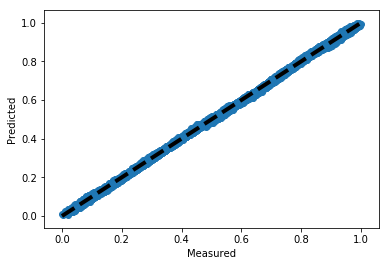

In [114]:
fig, ax=plt.subplots()
ax.scatter(y[:],pred1[:])
ax.plot([y[:].min(), y[:].max()],[y[:].min(), y[:].max()],'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [115]:
pd.DataFrame({'real':list(test["force"][timestep:]),'pred':list(pred1_back[:,1])} ) .to_csv('train_data_lstmyusra1.csv',index=False)

In [61]:


#model.save('train_data_lstm_yusra.h5')

